# Red noise and DM noise fitting examples

This notebook provides an example on how to fit for red noise
and DM noise using PINT using simulated datasets.

We will use the `PLRedNoise` and `PLDMNoise` models to generate
noise realizations (these models provide Fourier Gaussian process
descriptions of achromatic red noise and DM noise respectively).

We will fit the generated datasets using the `WaveX` and `DMWaveX` models,
which provide deterministic Fourier representations of achromatic red noise
and DM noise respectively.

Finally, we will convert the `WaveX`/`DMWaveX` amplitudes into spectral
parameters and compare them with the injected values.

In [1]:
from pint import DMconst
from pint.models import get_model
from pint.simulation import make_fake_toas_uniform
from pint.logging import setup as setup_log
from pint.fitter import WLSFitter
from pint.utils import (
    dmwavex_setup,
    find_optimal_nharms,
    wavex_setup,
    plrednoise_from_wavex,
    pldmnoise_from_dmwavex,
)

from io import StringIO
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from copy import deepcopy

setup_log(level="WARNING")

1

## Red noise fitting

### Simulation
The first step is to generate a simulated dataset for demonstration.
Note that we are adding PHOFF as a free parameter. This is required
for the fit to work properly.

In [2]:
par_sim = """
    PSR           SIM3
    RAJ           05:00:00     1
    DECJ          15:00:00     1
    PEPOCH        55000
    F0            100          1
    F1            -1e-15       1 
    PHOFF         0            1
    DM            15           1
    TNREDAMP      -13
    TNREDGAM      3.5
    TNREDC        30
    TZRMJD        55000
    TZRFRQ        1400 
    TZRSITE       gbt
    UNITS         TDB
    EPHEM         DE440
    CLOCK         TT(BIPM2019)
"""

m = get_model(StringIO(par_sim))

In [3]:
# Now generate the simulated TOAs.
ntoas = 2000
toaerrs = np.random.uniform(0.5, 2.0, ntoas) * u.us
freqs = np.linspace(500, 1500, 8) * u.MHz

t = make_fake_toas_uniform(
    startMJD=53001,
    endMJD=57001,
    ntoas=ntoas,
    model=m,
    freq=freqs,
    obs="gbt",
    error=toaerrs,
    add_noise=True,
    add_correlated_noise=True,
    name="fake",
    include_bipm=True,
    include_gps=True,
    multi_freqs_in_epoch=True,
)

### Optimal number of harmonics
The optimal number of harmonics can be estimated by minimizing the
Akaike Information Criterion (AIC). This is implemented in the
`pint.utils.find_optimal_nharms` function.

In [4]:
m1 = deepcopy(m)
m1.remove_component("PLRedNoise")

nharm_opt, d_aics = find_optimal_nharms(m1, t, "WaveX", 30)

print("Optimum no of harmonics = ", nharm_opt)

Optimum no of harmonics =  15


In [5]:
print(np.argmin(d_aics))

15


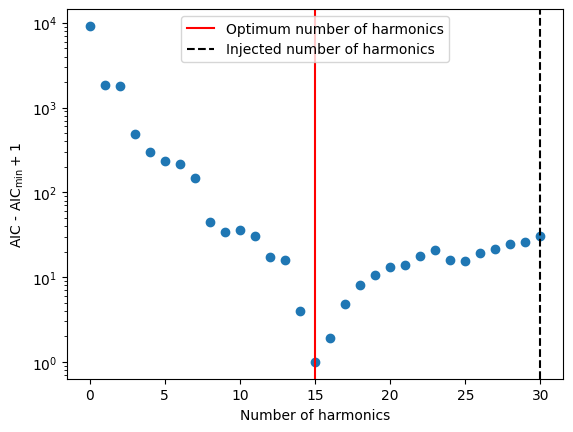

In [6]:
# The Y axis is plotted in log scale only for better visibility.
plt.scatter(list(range(len(d_aics))), d_aics + 1)
plt.axvline(nharm_opt, color="red", label="Optimum number of harmonics")
plt.axvline(
    int(m.TNREDC.value), color="black", ls="--", label="Injected number of harmonics"
)
plt.xlabel("Number of harmonics")
plt.ylabel("AIC - AIC$_\\min{} + 1$")
plt.legend()
plt.yscale("log")
# plt.savefig("sim3-aic.pdf")

In [7]:
# Now create a new model with the optimum number of harmonics
m2 = deepcopy(m1)
Tspan = t.get_mjds().max() - t.get_mjds().min()
wavex_setup(m2, T_span=Tspan, n_freqs=nharm_opt, freeze_params=False)

ftr = WLSFitter(t, m2)
ftr.fit_toas(maxiter=10)
m2 = ftr.model

print(m2)

# Created: 2024-05-10T08:38:27.229955
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                  SIM3
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567181482
FINISH             56985.0000000464535995
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2025.0830501956489
CHI2R                   1.031626617521981
TRES                1.0206446540757747264
RAJ                      4:59:59.99990140 1 0.00009823307049469972
DECJ                    14:59:59.99665920 1 0.01098953085697591987
PMRA                                  0.0
PMDEC                                 0.0
PX                 

### Estimating the spectral parameters from the WaveX fit.

In [8]:
# Get the Fourier amplitudes and powers and their uncertainties.
idxs = np.array(m2.components["WaveX"].get_indices())
a = np.array([m2[f"WXSIN_{idx:04d}"].quantity.to_value("s") for idx in idxs])
da = np.array([m2[f"WXSIN_{idx:04d}"].uncertainty.to_value("s") for idx in idxs])
b = np.array([m2[f"WXCOS_{idx:04d}"].quantity.to_value("s") for idx in idxs])
db = np.array([m2[f"WXCOS_{idx:04d}"].uncertainty.to_value("s") for idx in idxs])
print(len(idxs))

P = (a**2 + b**2) / 2
dP = ((a * da) ** 2 + (b * db) ** 2) ** 0.5

f0 = (1 / Tspan).to_value(u.Hz)
fyr = (1 / u.year).to_value(u.Hz)

15


In [9]:
# We can create a `PLRedNoise` model from the `WaveX` model.
# This will estimate the spectral parameters from the `WaveX`
# amplitudes.
m3 = plrednoise_from_wavex(m2)
print(m3)

# Created: 2024-05-10T08:38:27.270388
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                  SIM3
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567181482
FINISH             56985.0000000464535995
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2025.0830501956489
CHI2R                   1.031626617521981
TRES                1.0206446540757747264
RAJ                      4:59:59.99990140 1 0.00009823307049469972
DECJ                    14:59:59.99665920 1 0.01098953085697591987
PMRA                                  0.0
PMDEC                                 0.0
PX                 

15 15


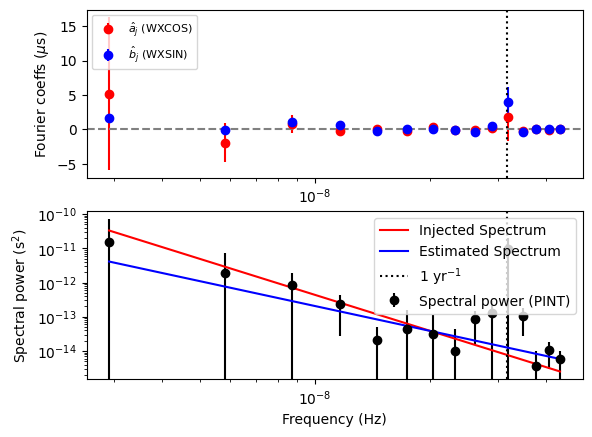

In [10]:
# Now let us plot the estimated spectrum with the injected
# spectrum.
plt.subplot(211)
plt.errorbar(
    idxs * f0,
    b * 1e6,
    db * 1e6,
    ls="",
    marker="o",
    label="$\\hat{a}_j$ (WXCOS)",
    color="red",
)
plt.errorbar(
    idxs * f0,
    a * 1e6,
    da * 1e6,
    ls="",
    marker="o",
    label="$\\hat{b}_j$ (WXSIN)",
    color="blue",
)
plt.axvline(fyr, color="black", ls="dotted")
plt.axhline(0, color="grey", ls="--")
plt.ylabel("Fourier coeffs ($\mu$s)")
plt.xscale("log")
plt.legend(fontsize=8)

plt.subplot(212)
plt.errorbar(
    idxs * f0, P, dP, ls="", marker="o", label="Spectral power (PINT)", color="k"
)
P_inj = m.components["PLRedNoise"].get_noise_weights(t)[::2][:nharm_opt]
plt.plot(idxs * f0, P_inj, label="Injected Spectrum", color="r")
P_est = m3.components["PLRedNoise"].get_noise_weights(t)[::2][:nharm_opt]
print(len(idxs), len(P_est))
plt.plot(idxs * f0, P_est, label="Estimated Spectrum", color="b")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power (s$^2$)")
plt.xlabel("Frequency (Hz)")
plt.axvline(fyr, color="black", ls="dotted", label="1 yr$^{-1}$")
plt.legend()

Note the outlier in the 1 year^-1 bin. This is caused by the covariance with RA and DEC, which introduce a delay with the same frequency.

## DM noise fitting
Let us now do a similar kind of analysis for DM noise.

In [11]:
par_sim = """
    PSR           SIM4
    RAJ           05:00:00     1
    DECJ          15:00:00     1
    PEPOCH        55000
    F0            100          1
    F1            -1e-15       1 
    PHOFF         0            1
    DM            15           1
    TNDMAMP       -13
    TNDMGAM       3.5
    TNDMC         30
    TZRMJD        55000
    TZRFRQ        1400 
    TZRSITE       gbt
    UNITS         TDB
    EPHEM         DE440
    CLOCK         TT(BIPM2019)
"""

m = get_model(StringIO(par_sim))

In [12]:
# Generate the simulated TOAs.
ntoas = 2000
toaerrs = np.random.uniform(0.5, 2.0, ntoas) * u.us
freqs = np.linspace(500, 1500, 8) * u.MHz

t = make_fake_toas_uniform(
    startMJD=53001,
    endMJD=57001,
    ntoas=ntoas,
    model=m,
    freq=freqs,
    obs="gbt",
    error=toaerrs,
    add_noise=True,
    add_correlated_noise=True,
    name="fake",
    include_bipm=True,
    include_gps=True,
    multi_freqs_in_epoch=True,
)

In [13]:
# Find the optimum number of harmonics by minimizing AIC.
m1 = deepcopy(m)
m1.remove_component("PLDMNoise")

m2 = deepcopy(m1)

nharm_opt, d_aics = find_optimal_nharms(m2, t, "DMWaveX", 30)
print("Optimum no of harmonics = ", nharm_opt)

Optimum no of harmonics =  30


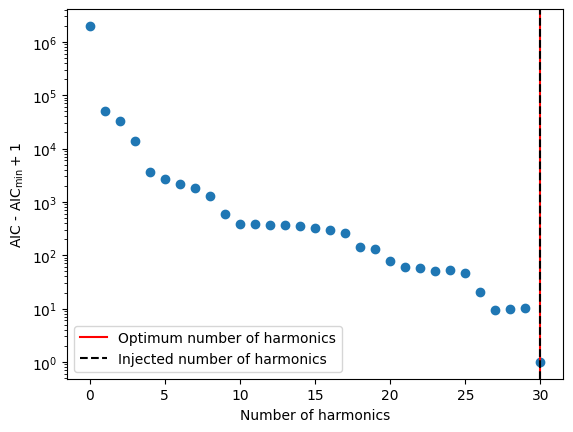

In [14]:
# The Y axis is plotted in log scale only for better visibility.
plt.scatter(list(range(len(d_aics))), d_aics + 1)
plt.axvline(nharm_opt, color="red", label="Optimum number of harmonics")
plt.axvline(
    int(m.TNDMC.value), color="black", ls="--", label="Injected number of harmonics"
)
plt.xlabel("Number of harmonics")
plt.ylabel("AIC - AIC$_\\min{} + 1$")
plt.legend()
plt.yscale("log")
# plt.savefig("sim3-aic.pdf")

In [15]:
# Now create a new model with the optimum number of
# harmonics
m2 = deepcopy(m1)

Tspan = t.get_mjds().max() - t.get_mjds().min()
dmwavex_setup(m2, T_span=Tspan, n_freqs=nharm_opt, freeze_params=False)

ftr = WLSFitter(t, m2)
ftr.fit_toas(maxiter=10)
m2 = ftr.model

print(m2)

# Created: 2024-05-10T08:39:35.998914
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                  SIM4
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567938079
FINISH             56985.0000000475293866
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1973.6751436061227
CHI2R                  1.0210424953989254
TRES               0.96597401754761965883
RAJ                      4:59:59.99999829 1 0.00000185667363236908
DECJ                    15:00:00.00004905 1 0.00015863370906534876
PMRA                                  0.0
PMDEC                                 0.0
PX                 

### Estimating the spectral parameters from the `DMWaveX` fit.

In [16]:
# Get the Fourier amplitudes and powers and their uncertainties.
# Note that the `DMWaveX` amplitudes have the units of DM.
# We multiply them by a constant factor to convert them to dimensions
# of time so that they are consistent with `PLDMNoise`.
scale = DMconst / (1400 * u.MHz) ** 2

idxs = np.array(m2.components["DMWaveX"].get_indices())
a = np.array(
    [(scale * m2[f"DMWXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs]
)
da = np.array(
    [(scale * m2[f"DMWXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs]
)
b = np.array(
    [(scale * m2[f"DMWXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs]
)
db = np.array(
    [(scale * m2[f"DMWXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs]
)
print(len(idxs))

P = (a**2 + b**2) / 2
dP = ((a * da) ** 2 + (b * db) ** 2) ** 0.5

f0 = (1 / Tspan).to_value(u.Hz)
fyr = (1 / u.year).to_value(u.Hz)

30


In [17]:
# We can create a `PLDMNoise` model from the `DMWaveX` model.
# This will estimate the spectral parameters from the `DMWaveX`
# amplitudes.
m3 = pldmnoise_from_dmwavex(m2)
print(m3)

# Created: 2024-05-10T08:39:36.054004
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                  SIM4
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567938079
FINISH             56985.0000000475293866
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1973.6751436061227
CHI2R                  1.0210424953989254
TRES               0.96597401754761965883
RAJ                      4:59:59.99999829 1 0.00000185667363236908
DECJ                    15:00:00.00004905 1 0.00015863370906534876
PMRA                                  0.0
PMDEC                                 0.0
PX                 

30 30


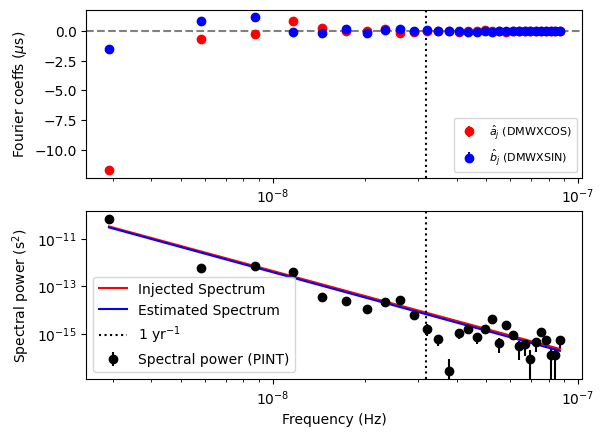

In [18]:
# Now let us plot the estimated spectrum with the injected
# spectrum.
plt.subplot(211)
plt.errorbar(
    idxs * f0,
    b * 1e6,
    db * 1e6,
    ls="",
    marker="o",
    label="$\\hat{a}_j$ (DMWXCOS)",
    color="red",
)
plt.errorbar(
    idxs * f0,
    a * 1e6,
    da * 1e6,
    ls="",
    marker="o",
    label="$\\hat{b}_j$ (DMWXSIN)",
    color="blue",
)
plt.axvline(fyr, color="black", ls="dotted")
plt.axhline(0, color="grey", ls="--")
plt.ylabel("Fourier coeffs ($\mu$s)")
plt.xscale("log")
plt.legend(fontsize=8)

plt.subplot(212)
plt.errorbar(
    idxs * f0, P, dP, ls="", marker="o", label="Spectral power (PINT)", color="k"
)
P_inj = m.components["PLDMNoise"].get_noise_weights(t)[::2][:nharm_opt]
plt.plot(idxs * f0, P_inj, label="Injected Spectrum", color="r")
P_est = m3.components["PLDMNoise"].get_noise_weights(t)[::2][:nharm_opt]
print(len(idxs), len(P_est))
plt.plot(idxs * f0, P_est, label="Estimated Spectrum", color="b")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power (s$^2$)")
plt.xlabel("Frequency (Hz)")
plt.axvline(fyr, color="black", ls="dotted", label="1 yr$^{-1}$")
plt.legend()